In [1]:
import numpy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

## Data Collection & Preparation

In [2]:
data = pd.read_csv('../data/AER_credit_card_data.csv')
data.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


In [4]:
data.card.value_counts()

yes    1023
no      296
Name: card, dtype: int64

In [5]:
card_dict = {'yes':1,'no':0}
data.card = data.card.map(card_dict)

In [6]:
data.card.value_counts()

1    1023
0     296
Name: card, dtype: int64

In [7]:
numeric_cols = [col for col in list(data.select_dtypes([int,float]).columns) if col !='card']
categorical_cols = list(data.select_dtypes('O'))

In [8]:
numeric_cols

['reports',
 'age',
 'income',
 'share',
 'expenditure',
 'dependents',
 'months',
 'majorcards',
 'active']

In [9]:
categorical_cols

['owner', 'selfemp']

In [10]:
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size= 0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

df_train.drop('card', axis=1, inplace=True)
df_val.drop('card', axis=1, inplace=True)
df_test.drop('card', axis=1, inplace=True)

## Q1
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score and compute AUC with the card variable.
- Use the training dataset for that.
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AU
- reports
- dependents
- active
- share

In [11]:
result_dict = {'feature':[],'roc_auc_score':[]}
for col in numeric_cols:
    result = roc_auc_score(y_train,df_train[col])
    if result < 0.5:
        result = roc_auc_score(y_train, -df_train[col])
    result_dict['feature'].append(col)
    result_dict['roc_auc_score'].append(result)
    

In [12]:
pd.DataFrame(result_dict).sort_values('roc_auc_score',ascending=False)

,feature,roc_auc_score
4,expenditure,0.991042
3,share,0.989184
0,reports,0.716663
8,active,0.604317
2,income,0.590805
7,majorcards,0.534386
5,dependents,0.532776
6,months,0.529422
1,age,0.524002


Answer: share

In [13]:
features = ["reports", "age", "income", "share", "expenditure", "dependents", "months", 
            "majorcards", "active", "owner", "selfemp"]

In [14]:
train_dict = df_train[features].to_dict(orient='records')

In [15]:
dv = DictVectorizer(sparse=False)

In [16]:
X_train = dv.fit_transform(train_dict)

In [17]:
model =  LogisticRegression(solver='liblinear',C=1.0,max_iter=1000)

In [18]:
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [19]:
val_dict = df_val[features].to_dict(orient='records')

In [20]:
X_val = dv.transform(val_dict)

In [21]:
y_pred = model.predict_proba(X_val)[:,1]

In [22]:
numpy.round(roc_auc_score(y_val,y_pred),3)

0.995

Answer: 0.995

## Q3

Now let's compute precision and recall for our model.

- Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

- 0.1
- 0.3
- 0.6
- 0.8

In [23]:
def cmd(y_val, y_pred):
    scores = []
    thresholds = numpy.linspace(0,1,101)
    
    for t in thresholds:
        actual_positive = (y_val==1)
        actual_negative = (y_val==0)
        
        predicted_positive = (y_pred>=t)
        predicted_negative = (y_pred<t)
        
        tp = (actual_positive & predicted_positive).sum()
        
        fp = (actual_negative & predicted_positive).sum()
        
        tn = (actual_negative & predicted_negative).sum()
        
        fn = (actual_positive & predicted_negative).sum()
        
        scores.append((t, tp, fp, tn, fn))
        
    columns = ['threshold','tp','fp','tn','fn']
    
    df_scores = pd.DataFrame(scores, columns=columns)
    return df_scores
        
        

In [24]:
df_scores = cmd(y_val,y_pred)

In [25]:
df_scores['p'] = df_scores.tp/(df_scores.tp+df_scores.fp)
df_scores['r'] = df_scores.tp/(df_scores.tp+df_scores.fn)

In [26]:
df_scores

,threshold,tp,fp,tn,fn,p,r
0,0.00,211,53,0,0,0.799242,1.000000
1,0.01,211,34,19,0,0.861224,1.000000
2,0.02,211,31,22,0,0.871901,1.000000
3,0.03,211,24,29,0,0.897872,1.000000
4,0.04,211,22,31,0,0.905579,1.000000
...,...,...,...,...,...,...,...
96,0.96,204,0,53,7,1.000000,0.966825
97,0.97,203,0,53,8,1.000000,0.962085
98,0.98,203,0,53,8,1.000000,0.962085
99,0.99,202,0,53,9,1.000000,0.957346


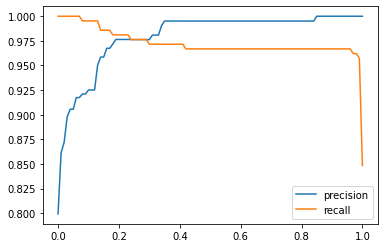

In [27]:
plt.plot(df_scores.threshold, df_scores.p, label = 'precision')
plt.plot(df_scores.threshold, df_scores.r, label = 'recall')
plt.legend()

In [28]:
df_scores[df_scores.p==df_scores.r]

,threshold,tp,fp,tn,fn,p,r
24,0.24,206,5,48,5,0.976303,0.976303
25,0.25,206,5,48,5,0.976303,0.976303
26,0.26,206,5,48,5,0.976303,0.976303
27,0.27,206,5,48,5,0.976303,0.976303
28,0.28,206,5,48,5,0.976303,0.976303
29,0.29,206,5,48,5,0.976303,0.976303


Answer: 0.3 (nearest value)

## Q4
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing $F_1$:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7


In [29]:
df_scores['f1'] = 2*df_scores.p*df_scores.r/(df_scores.p+df_scores.r)

In [30]:
df_scores[df_scores.f1 == df_scores.f1 .max()]['threshold']

35    0.35
36    0.36
37    0.37
38    0.38
39    0.39
40    0.40
41    0.41
Name: threshold, dtype: float64

Answer : 0.4

## Q5
Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24


In [31]:
def train(df_train,y_train,C=1.0):
    train_dict = df_train[features].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train,y_train)
    return dv, model

def predict(df_val, dv, model):
    val_dict = df_val[features].to_dict(orient='records')
    
    X_val = dv.transform(val_dict)
    y_pred = model.predict_proba(X_val)[:,1]
    return y_pred
    

In [32]:
from sklearn.model_selection import KFold

In [33]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [34]:
scores = []
for train_index, val_index in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_index]
    df_val = df_full_train.iloc[val_index]
    
    y_train = df_train.card.values
    y_val = df_val.card.values
    
    dv, model = train(df_train, y_train)
    
    y_pred = predict(df_val,dv,model)
    auc = roc_auc_score(y_val,y_pred)
    
    scores.append(auc)
    

In [35]:
scores

[0.9941860465116279,
 0.9941176470588236,
 0.9943346508563901,
 0.9996107939802803,
 1.0]

In [36]:
numpy.mean(scores), numpy.std(scores).round(3)

(0.9964498276814243, 0.003)

Answer: 0.003

## Q6
Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [37]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores_dict= {'C':[],'mean_score':[]}

for C in [0.01, 0.1, 1, 10]:
    scores = []
    
    for train_index, val_index in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_index]
        df_val = df_full_train.iloc[val_index]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train,C=C)

        y_pred = predict(df_val,dv,model)
        auc = roc_auc_score(y_val,y_pred)

        scores.append(auc)
        
    scores_dict['C'].append(C)
    scores_dict['mean_score'].append(numpy.mean(scores))
    
    
    

In [38]:
pd.DataFrame(scores_dict).sort_values('mean_score',ascending=False)

,C,mean_score
2,1.00,0.996450
3,10.00,0.996389
1,0.10,0.995056
0,0.01,0.991881


Answer: 1